This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week5` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

# Problem 5.3. Density Estimation.

In this problem, we will first plot rug plots and histograms of travel time in the flights data. We then use Seaborn, Scipy, and Scikit-learn to calculate and plot Kernel Density Estimation (KDE).

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
from sklearn.neighbors import KernelDensity

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We use the `AirTime` column at the Willard airport.

In [2]:
df = pd.read_csv(
    '/home/data_scientist/data/2001.csv',
    encoding='latin-1',
    usecols=(13, 16)
    )

In [3]:
local = df[df['Origin'] == 'CMI']
local = local.drop(['Origin'], axis=1) # we don't need the Origin column anymore.
local.dropna(inplace=True)

## Rug plots

- Plot rug plots. See lesson the notebook, docsting, test cases, and sample plots for details.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/rug_no_jitter.png)

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/rug_jittered.png)

In [4]:
def plot_rugplot(df, column='AirTime', jitter=0.0, seed=0):
    '''
    Plots a rug plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    jitter: An int or float. Default: 0.
            If jitter > 0, uses numpy.random.normal() to draw
            random samples from a normal distribution with zero mean
            and standard deviatation equal to "jitter".
    seed: An int. Used by numpy.random.seed().
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    
    # YOUR CODE HERE
    data = df[column].values
    if jitter != 0:
        np.random.seed(seed)
        data = data + np.random.normal(0, jitter, len(data))
        
    sns.set_style('white')
    fig, axs = plt.subplots()
    ax = sns.rugplot(a = data, height=0.5, c='red')
    ax.set_yticks([])
    ax.set_xlabel('Air time (minutes)')
    sns.despine(left=True, offset=2, trim=True)
    
    return ax

A rug plot with no jitter.

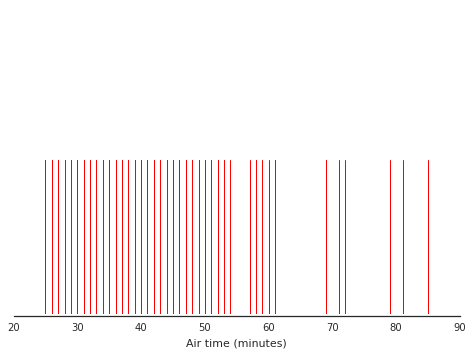

In [5]:
rug_no_jitter = plot_rugplot(df=local, jitter=0, seed=0)

In [6]:
assert_is_instance(rug_no_jitter, mpl.axes.Axes)
assert_equal(len(rug_no_jitter.lines), len(local))

for i in range(len(local)):
    xdata, ydata = rug_no_jitter.lines[i].get_xydata().T
    assert_array_equal(xdata, local.iloc[i, 0])
    assert_equal(ydata[1] - ydata[0] > 0, True)
    
assert_is_not(rug_no_jitter.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

A rug plot with random jitter. Adding jitter improves visualization.

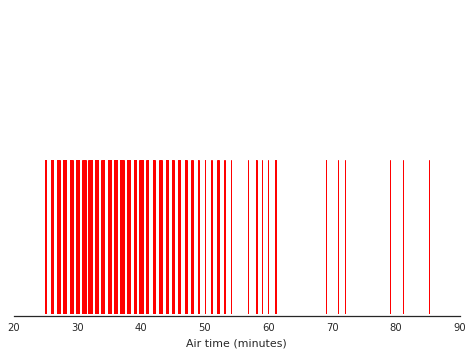

In [7]:
rug_jittered = plot_rugplot(df=local, jitter=0.1, seed=0)

In [8]:
assert_equal(len(rug_jittered.lines), len(local))

np.random.seed(0)
for i in range(len(local)):
    xdata, ydata = rug_jittered.lines[i].get_xydata().T
    assert_equal(xdata[0], xdata[1])
    assert_almost_equal(xdata[0], local.iloc[i, 0] + np.random.normal(0, 0.1)) # jitter is 0.1
    assert_equal(ydata[1] - ydata[0] > 0, True)
    
assert_is_not(rug_jittered.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

## Histograms

- Plot histograms. See the lesson notebook, docsting, test cases, and sample plots for details.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/hist_10_bins.png)

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/hist_50_bins.png)

In [9]:
def plot_histogram(df, bins, column='AirTime', normed=False):
    '''
    Plots a histogram.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    normed: If true, the integral of the histogram will sum to 1
            (i.e. normalized) to form a probability density.
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    
    # YOUR CODE HERE
    fig, ax = plt.subplots()
    ax.hist(df[column], bins=bins, normed=normed, alpha=0.5)
    ax.set_xlabel('Airtime (minutes)', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('Hisogram with ' + str(bins) + ' bins')
    sns.despine(ax=ax, offset=5, trim=True)

    return ax

A histogram with 10 bins.

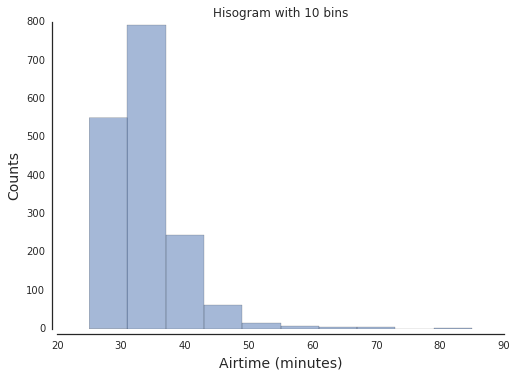

In [10]:
hist_10_bins = plot_histogram(df=local, bins=10)

In [11]:
assert_is_instance(hist_10_bins, mpl.axes.Axes)
patches = hist_10_bins.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
counts_a = [550, 792, 245,  61,  15,   7,   4,   4,   0,   3]
                    
for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_equal(patches[i].get_height(), counts_a[i])

A histogram with 50 bins. We see that changing the number of bins can have a significant effect on the shape of a histogram. As we will see shortly, KDE is less affected by the choice of bins and thus a better alternative.

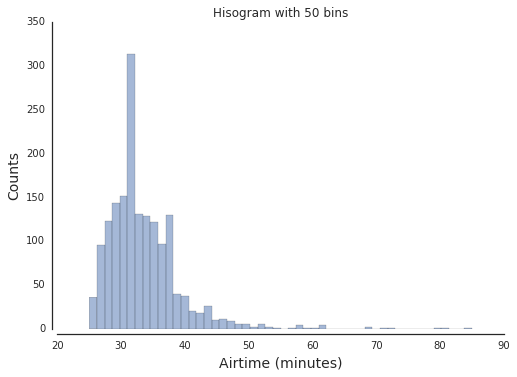

In [12]:
hist_50_bins = plot_histogram(df=local, bins=50)

In [13]:
assert_is_instance(hist_50_bins, mpl.axes.Axes)
patches = hist_50_bins.patches
assert_equal(len(patches), 50)

## distplot

- Use [seaborn.distplot](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.distplot.html) to plot a histogram, a KDE, and a rug plot, all in the same figure. See lesson notebook, docsting, test cases, and sample plot for details.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/dist_10_bins.png)

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/dist_50_bins.png)

In [14]:
def plot_distplot(df, bins, column='AirTime'):
    '''
    Plots a "distplot".
    
    Parameters
    ----------
    df: A pandas.DataFrame
    bins: The number of bins
    column: The column to use in "df"
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    
    # YOUR CODE HERE
    ax = sns.distplot(df[column], kde=True, rug=True, bins=bins)
    ax.set_xlabel('Airtime (minutes)', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('dispot with ' + str(bins) + ' bins')
    sns.despine(offset=5, trim=True)
    
    return ax

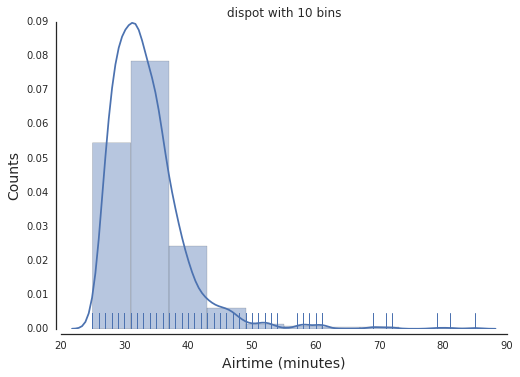

In [15]:
dist_10_bins = plot_distplot(df=local, bins=10)

In [16]:
assert_is_instance(dist_10_bins, mpl.axes.Axes)

# test histogram
patches = dist_10_bins.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde + rug plots
lines = dist_10_bins.lines
assert_equal(len(dist_10_bins.lines), len(local) + 1) # 1 kde + rug plots

# test kde
kdex, kdey = dist_10_bins.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# test rug plots
for i in range(len(local)):
    rugx, rugy = dist_10_bins.lines[i + 1].get_xydata().T
    assert_array_equal(rugx, local.iloc[i, 0])
    assert_equal(rugy[1] - rugy[0] > 0, True)
    
# check label texts
assert_is_not(len(dist_10_bins.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(dist_10_bins.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

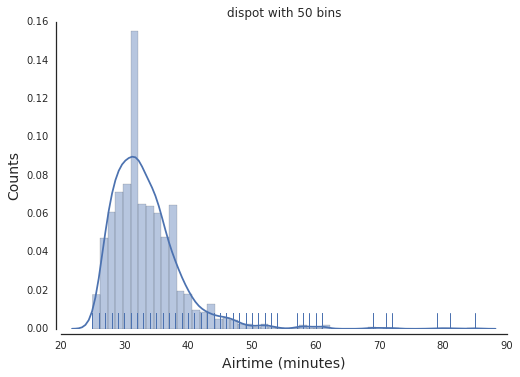

In [17]:
dist_50_bins = plot_distplot(df=local, bins=50)

In [18]:
assert_is_instance(dist_50_bins, mpl.axes.Axes)
# test histogram
patches = dist_50_bins.patches
assert_equal(len(patches), 50)

## Silverman's rule of thumb

- Write a function named `get_silverman_bandwidth()` that calculates the optimal KDE bandwidth using Silverman's rule of thumb. The formula for the optimal choice of bandwidth $h$ is given by

$h = \left( \frac{4{\hat\sigma}^5}{3n} \right)^{\frac{1}{5}} \approx 1.06 \hat\sigma n^{-1/5}$

where $\hat\sigma$ is the standard deviation of the samples. Source: [Wikipedia](https://en.wikipedia.org/wiki/Kernel_density_estimation#Practical_estimation_of_the_bandwidth)

In [19]:
def get_silverman_bandwidth(df, column='AirTime'):
    '''
    Calculates bandwidth for KDE using Silverman's rule of thumb.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    
    Returns
    -------
    A float
    '''
    
    # YOUR CODE HERE
    data = df[column].values
    sigma = np.std(data, ddof=0)
    n = len(data)
    bw = 1.06 * sigma * n ** (-1 / 5.)
    
    return bw

In [20]:
rs = np.random.RandomState(0)
bw_t = pd.DataFrame({'AirTime': rs.randn(100)})
assert_almost_equal(get_silverman_bandwidth(bw_t), 0.425, 3)

rs = np.random.RandomState(0)
bw_t = pd.DataFrame({'AirTime': rs.randn(200)})
assert_almost_equal(get_silverman_bandwidth(bw_t), 0.375, 3)

## Gaussian Kernels

- Use `get_silverman_bandwidth()` and [stats.norm().pdf()](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html) to generate Guassian kernels. See lesson notebook, docsting, and test cases for details.

In [21]:
def get_kernels(df, support, column='AirTime'):
    '''
    Generates Gaussian kernels.
    
    Parameters
    ----------
    df: A pandas.DataFrame.
    support: Input data points for the probabilit density function.
    column: The column that will be used in "df"
    
    Returns
    -------
    A 2-d numpy array
    '''
    
    # YOUR CODE HERE

    bw = get_silverman_bandwidth(df, column='AirTime')
    data = df[column].values
    kernels = []
    for d in data:
        kernel = stats.norm(d, bw).pdf(support)
        kernels.append(kernel)   
    
    return kernels

In [22]:
support_t = np.linspace(0, 1, 5)
rs = np.random.RandomState(0)
df_t = pd.DataFrame({'AirTime': rs.rand(2)})
kernels_t = get_kernels(df=df_t, support=support_t)
kernels_a = np.array(
    [[4.13769545e-11, 2.66353480e-03, 4.24566728e+00, 1.67579644e-01, 1.63788836e-07],
     [7.36686859e-19, 5.51357055e-08, 1.02181124e-01, 4.68917176e+00, 5.32855352e-03]]
    )
assert_array_almost_equal(kernels_t, kernels_a)

## Kernel density estimate

- Sum up the Gaussian kernels from `get_kernels()` and normalize by the total area. See lesson notebook, docsting, and test cases for details.

In [23]:
def normalize_kernels(support, kernels):
    '''
    Sums up the individual kernels and normalizes by total area.

    Parameters
    ----------
    support: A 1-d numpy array.
             Input data points for the probabilit density function.
    kernels: A 2-d numpy array.
             Kernels generated from "get_kernels()"
             
    Returns
    -------
    A 1-d numpy array
    '''
    
    # YOUR CODE HERE
    density = np.sum(kernels, axis=0)
    density = density / integrate.trapz(density, support)
    
    return density

In [24]:
# We use the same kernels_t and support_t from the previous test for get_kernels
density_t = normalize_kernels(support=support_t, kernels=kernels_t)
density_a = np.array(
    [1.797059e-11, 1.156834e-03, 1.888331e+00, 2.109355e+00, 2.314336e-03]
    )
assert_array_almost_equal(density_t, density_a)

## Plot KDE (scipy version)

- Use `get_kernels()` and `normalize_kernels()` to plot a KDE and a histogram in the same figure.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/kde_scipy.png)

In [25]:
def plot_scipy_kde(df, support, bins=50):
    '''
    Plots a KDE (using scipy functions) over a histogram.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    support: A 1-d numpy array.
             Input data points for the probabilit density function.
    
    Returns
    -------
    A matplotlib.axes.Axes instance.
    '''
    
    # YOUR CODE HERE
    kernels = get_kernels(df, support)
    density = normalize_kernels(support, kernels)
    ax = plot_histogram(df, bins=bins, normed=True)
    ax.plot(support, density, linewidth=2)

    return ax

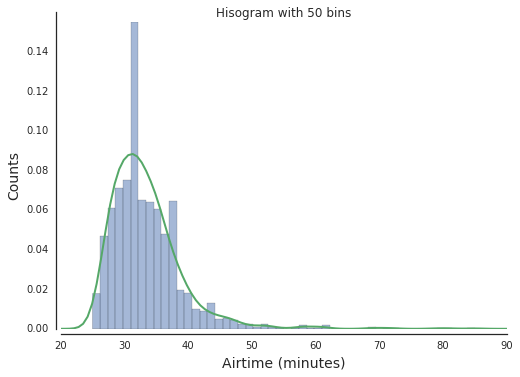

In [26]:
support = np.linspace(20, 90, 100)
kde_scipy = plot_scipy_kde(df=local, support=support)

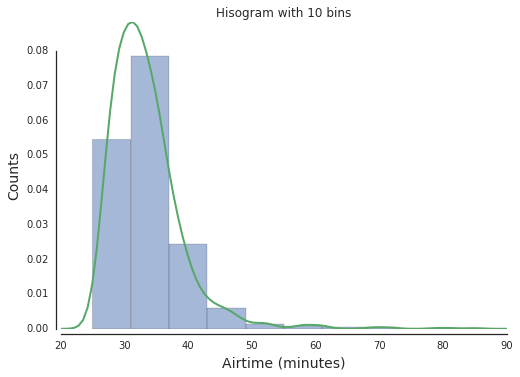

In [27]:
kde_scipy_t = plot_scipy_kde(df=local, support=support, bins=10)
assert_is_instance(kde_scipy_t, mpl.axes.Axes)

# test histogram
patches = kde_scipy_t.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde
lines = kde_scipy_t.lines
assert_equal(len(kde_scipy_t.lines), 1)
kdex, kdey = kde_scipy_t.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# check label texts
assert_is_not(len(kde_scipy_t.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(kde_scipy_t.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

## Plot KDE (sklearn version)

- Plot a KDE using the bandwidth calculated with Silverman's rule of thumb and [sklearn.neighbors.KernelDensity](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html). See lesson notebook, docsting, samplot plot, and test cases for details.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/kde_sklearn.png)

In [28]:
def plot_sklearn_kde(df, support, column='AirTime', bins=50):
    '''
    Plots a KDE and a histogram using sklearn.KernelDensity.
    Uses Gaussian kernels.
    The optimal bandwidth is calculated according to Silverman's rule of thumb.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    support: A 1-d numpy array.
             Input data points for the probabilit density function.
    
    Returns
    -------
    A matplotlib.axes.Axes instance.
    '''
    
    # YOUR CODE HERE
    bw = get_silverman_bandwidth(df, column=column)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    
    # Create the KDE, and return the support values.
    data = df[column].values
    kde.fit(data[:, np.newaxis])
    y = kde.score_samples(support[:, np.newaxis])

    # Plot thje results including underlying histogram
    fig, ax = plt.subplots()
    ax.hist(data, bins=bins, alpha=0.5, normed=True)
    ax.plot(support, np.exp(y))
    plt.xlabel('Airtime (minutes)', fontsize=14)
    plt.ylabel('Normalized counts', fontsize=14)
    plt.title('Kernel Density Plot', fontsize=14)
    sns.despine(offset=5, trim=True)
    
    return ax

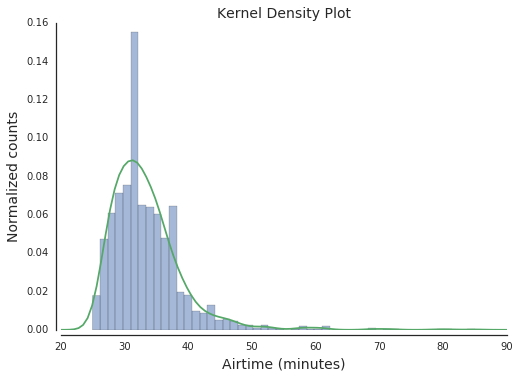

In [29]:
kde_sklearn = plot_sklearn_kde(df=local, support=support)

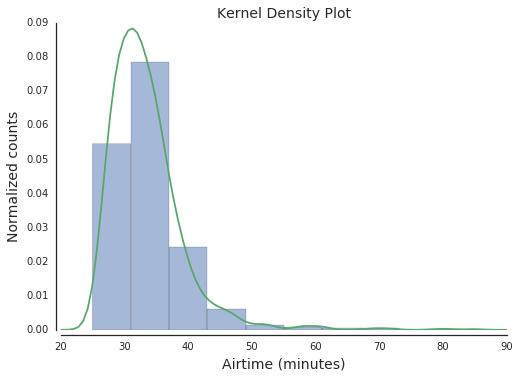

In [30]:
kde_sklearn_t = plot_sklearn_kde(df=local, support=support, bins=10)
assert_is_instance(kde_sklearn_t, mpl.axes.Axes)

# test histogram
patches = kde_sklearn_t.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde
lines = kde_sklearn_t.lines
assert_equal(len(kde_sklearn_t.lines), 1)
kdex, kdey = kde_sklearn_t.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# check label texts
assert_is_not(len(kde_sklearn_t.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(kde_sklearn_t.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")